In [1]:
%matplotlib inline
from pylab import *

# dumb stuff

Assume close to close for example.

* $\theta^0_t$ pre-action state
* $\theta^1_t = \theta^0_t + \epsilon + cost$ 
* $\theta^0_{t+1} = \theta^2_t$ post carry (interest and delta TV)

$$
\prod_t \sum_i \theta_{ti} (1 + Z_{ti})  
$$

In [142]:
def rebalance(theta, f, alpha=0.0010):
    """
    two dim. only pos.
    assume cost is alpha * abs(eps).
    state changes by (eps, - eps - alpha * abs(eps)
    want theta[0] / sum(theta) == f
    """
    s = f * (theta[0] + theta[1]) - theta[0]
    eps_neg = s / (1 + alpha * f)
    eps_pos = s / (1 - alpha * f)
    check = eps_neg * eps_pos
    assert check >= 0, 'got {} {} {}'.format(check, eps_neg, eps_pos)
    if eps_neg > 0:
        eps = eps_neg
    else:
        eps = eps_pos
    cost = alpha * np.abs(eps)
    theta_new = theta + np.array([eps, - eps - cost])
    return eps, cost, theta_new

def test_rebalance2():
    f = 0.1
    theta = np.array([f, 1 - f])
    theta = theta / np.sum(theta)
    theta = np.abs(theta)
    eps, cost, theta_new = rebalance(theta, f)
    assert eps == 0
    
test_rebalance2()

def test_rebalance():
    theta = np.abs(randn(2))
    theta = theta / np.sum(theta)
    theta = np.abs(theta)
    f = 0.9
    eps, cost, theta_new = rebalance(theta, f)
    assert np.allclose(theta_new[0] / np.sum(theta_new), f), '{}, {}'.format(theta_new[0], np.sum(theta_new))
    
test_rebalance()

In [187]:
m = 100
sigma = 0.05
r = 0.00 * (1 / 365)
mu = r + 0.0003

alpha = 0.005 # cost

print((mu - r) / sigma ** 2, r)

0.11999999999999997 0.0


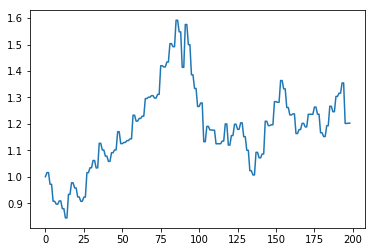

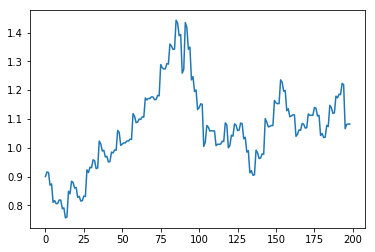

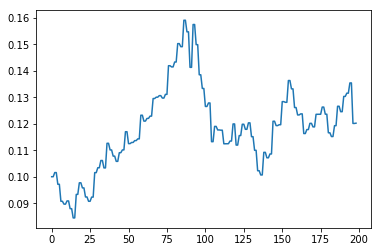

In [188]:
def get_one(f, m=m):
    th = np.array([f, 1 - f])
    theta = list()
    theta.append(th)
    for i in range(m-1):
        th0 = theta[-1]
        z = np.array([ mu + sigma * randn(), r])
        th1 = th0 * (1 + z)
        theta.append(th1)
        eps, cost, theta_new = rebalance(th1, f, alpha=alpha)
        theta.append(theta_new)
    theta = np.array(theta)
    return theta

th = get_one(0.9, m = 100)
plot(np.sum(th, axis=1))
figure()
plot(th[:,0])
figure()
plot(th[:,1])

CPU times: user 24.5 s, sys: 2.97 ms, total: 24.5 s
Wall time: 24.5 s


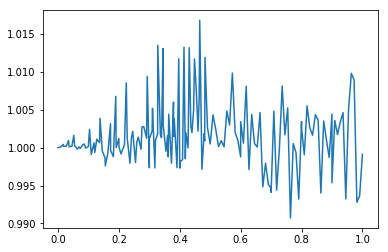

In [189]:
%%time
import mylib.tools
import functools


# def get_n(f, n=1000):
#     tasks = list()
#     for i in range(n):
#         tasks.append(functools.partial(get_one, f))
#     res = mylib.tools.run_tasks_in_parallel(*tasks, max_workers=4)
#     res = [x['result'].sum(axis=1) for x in res]
#     return pd.DataFrame(res)

def get_n(f, n=1000):
    # n number of samples to dist over
    res = list()
    for i in range(n):
        x = get_one(f)
        res.append(x.sum(axis=1))
    return pd.DataFrame(res)

tasks = list()
for i, f in enumerate(np.linspace(0, 0.5, 30)):
#     tasks.append(functools.partial(get_n, f))
# res = mylib.tools.run_tasks_in_parallel(*tasks, max_workers=4)
# res = [x['result'].iloc[:,-1].describe() for x in res]
    theta = get_n(f)
#     if i % 1 == 0:
#         figure()
#         plot(theta.iloc[::10,:].T, '-', alpha=0.1)
#         plot(theta.median())
#         plot(theta.mean())
#         title(f)
#         show()
    results[f] = theta.iloc[:,-1].describe()

results = pd.DataFrame(results).sort_index(axis=1)

s = results.T
s['mean'].plot()


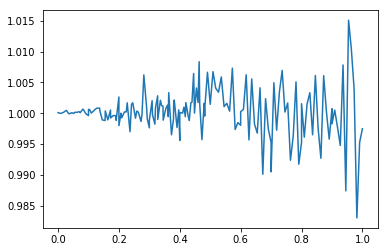

In [167]:
s['50%'].plot()

In [83]:
%%time
import extractors as e
df = e.e.pdr_yahoo_price_volume.load()

/home/cottrell/dev/pandas-datareader/pandas_datareader/iex/stats.py:24: UnstableAPIWarning: Daily statistics is not working due to issues with the IEX API
  'IEX API', UnstableAPIWarning)


read_parquet /home/cottrell/projects/data/extractors/pdr/yahoo_price_volume
... took 14.36774468421936 seconds
coalescing to latest by ['symbol', 'date']
df.shape = (10369237, 10) (before)
df.shape = (10330535, 9) (after)
... took 2.1431872844696045 seconds
CPU times: user 19.9 s, sys: 3.61 s, total: 23.5 s
Wall time: 17 s


# limit to symbols with recent prices

In [622]:
%%time
s = df[df.date > '2015-01-01'].symbol.value_counts()
print(s.shape)
s = s[s>1000]
d = df[df.symbol.isin(s.index)]
d.symbol.cat.remove_unused_categories(inplace=True)
d = d.sort_values(['symbol', 'date']) # IMPORTANT
print(d.shape, d.symbol.nunique(), d.date.nunique())

(7339,)
(9380211, 9) 4522 2277
CPU times: user 6.32 s, sys: 829 ms, total: 7.15 s
Wall time: 2.82 s


# Fix errors

In [623]:
i = d[['high', 'low', 'open', 'close']] == 0
d[i.any(axis=1)]

,date,high,low,open,close,volume,adj close,product,symbol
3661425,2018-12-19,6.1,6.1,0.0,6.1,12.0,6.1,stocks,bebe


In [624]:
%%time
for k in ['high', 'low', 'open', 'close']:
    d[k] = np.where(i[k], np.nan, d[k].values)

CPU times: user 624 ms, sys: 164 ms, total: 788 ms
Wall time: 152 ms


In [625]:
d[i.any(axis=1)]

,date,high,low,open,close,volume,adj close,product,symbol
3661425,2018-12-19,6.1,6.1,NaN,6.1,12.0,6.1,stocks,bebe


In [636]:
d.head()

,date,high,low,open,close,volume,adj close,product,symbol,high_lag,low_lag,open_open,open_close,close_open,close_close,best,worst
10,2010-07-21,25.100000,24.700001,25.100000,24.700001,42000.0,23.491602,etfs,aadr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2010-07-22,25.420000,25.129999,25.420000,25.260000,17500.0,24.024206,etfs,aadr,25.100000,24.700001,1.012749,1.006374,1.029150,1.022672,1.029150,1.001195
12,2010-07-23,25.540001,25.080000,25.540001,25.280001,8600.0,24.043226,etfs,aadr,25.420000,25.129999,1.004721,0.994493,1.011085,1.000792,1.016315,0.986625
13,2010-07-26,25.400000,25.219999,25.400000,25.370001,18900.0,24.128824,etfs,aadr,25.540001,25.080000,0.994518,0.993344,1.004747,1.003560,1.012759,0.987471
14,2010-07-27,25.290001,25.200001,25.250000,25.290001,8200.0,24.052738,etfs,aadr,25.400000,25.219999,0.994095,0.995669,0.995270,0.996847,1.002776,0.992126


# Data tricks

enrichment

In [626]:
good_lag = d.symbol == d.symbol.shift(1)
good_mask = lambda x: np.where(good_lag, x, np.nan)

In [627]:
for kk in ['high', 'low']:
    d[kk + '_lag'] = d[kk].shift(1)
cols = ['best', 'worst']
for kk in ['open', 'close']:
    for kkk in ['open', 'close']:
        name = '{}_{}'.format(kk, kkk)
        cols.append(name)
        d[name] = good_mask(d[kkk] / d[kk].shift(1))
d['best'] = good_mask(d.high / d.low_lag)
d['worst'] = good_mask(d.low / d.high_lag)
d.head()

,date,high,low,open,close,volume,adj close,product,symbol,high_lag,low_lag,open_open,open_close,close_open,close_close,best,worst
10,2010-07-21,25.100000,24.700001,25.100000,24.700001,42000.0,23.491602,etfs,aadr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2010-07-22,25.420000,25.129999,25.420000,25.260000,17500.0,24.024206,etfs,aadr,25.100000,24.700001,1.012749,1.006374,1.029150,1.022672,1.029150,1.001195
12,2010-07-23,25.540001,25.080000,25.540001,25.280001,8600.0,24.043226,etfs,aadr,25.420000,25.129999,1.004721,0.994493,1.011085,1.000792,1.016315,0.986625
13,2010-07-26,25.400000,25.219999,25.400000,25.370001,18900.0,24.128824,etfs,aadr,25.540001,25.080000,0.994518,0.993344,1.004747,1.003560,1.012759,0.987471
14,2010-07-27,25.290001,25.200001,25.250000,25.290001,8200.0,24.052738,etfs,aadr,25.400000,25.219999,0.994095,0.995669,0.995270,0.996847,1.002776,0.992126


In [637]:
g = d.dropna().groupby('symbol')[['open_open', 'open_close', 'close_open', 'close_close', 'best', 'worst']]

s = g.quantile([0.25, 0.5, 0.75])

In [644]:
s.index.names = ['symbol', 'q']

In [645]:
# rough idea
s.groupby(level='q').mean()

,open_open,open_close,close_open,close_close,best,worst
q,,,,,,
0.25,0.989349,0.986066,0.995622,0.990067,1.011502,0.965519
0.50,1.000195,0.999959,1.000192,1.000187,1.021421,0.979400
0.75,1.010712,1.013655,1.005144,1.010006,1.036004,0.989116


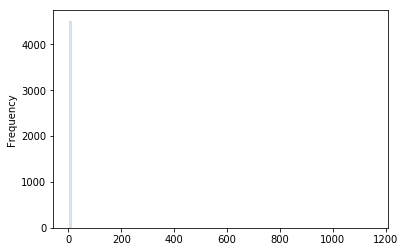

In [634]:
s['open_open']['mean'].plot(kind='hist', bins=100, alpha=0.2)

In [553]:
# remember these are SCALED! not actual returns ... should probably use truncated std as
# I am trying to use a low estimate of std to scale
g = d.groupby('symbol')
s = ((d.worst - g.worst.transform('mean')) / g.worst.transform('std')).dropna()

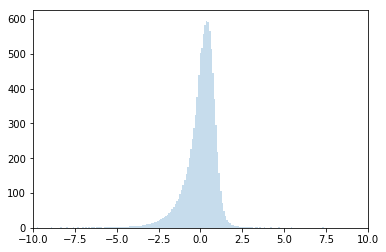

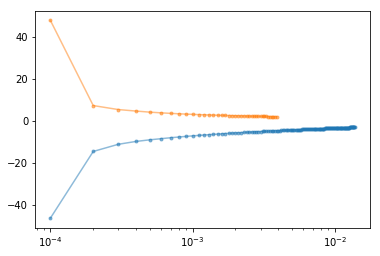

In [312]:
n = 10000
p = np.linspace(0, 1, 1 + n)
q = s.quantile(p)
p = p * (1 - 2/n) + 1/n # shift so we are not at the endpoints, I want 1/n not 0 etc
figure()
hist(q, bins=1000, alpha=0.25)
gca().set_xlim(-10, 10)
figure()
plot(p[q < -3], q[q < -3], '.-', alpha=0.5)
# gca().set_xscale('log')
# gca().set_ylim(q.min(), 0)
plot(1 - p[q > 2], q[q > 2], '.-', alpha=0.5)
gca().set_xscale('log')

# Q: how different are distributions after loc and scale?

In [267]:
dd = d.set_index(['date', 'symbol'])['worst'].unstack('symbol')
dd.shape

(2277, 4522)

In [268]:
dd = dd.dropna(how='all', axis=0)
dd.shape

(2276, 4522)

In [269]:
r = dd / dd.shift(1) - 1
r = r - r.mean()
r = r / r.std()

In [270]:
p = r.rank(pct=True)

<Figure size 432x288 with 0 Axes>

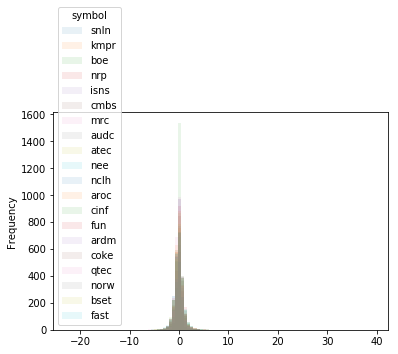

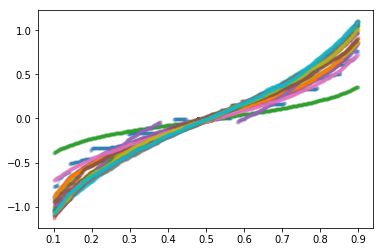

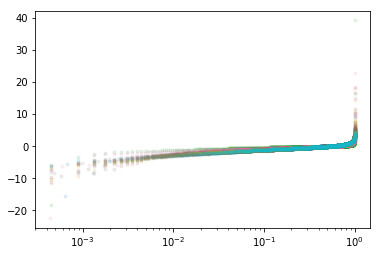

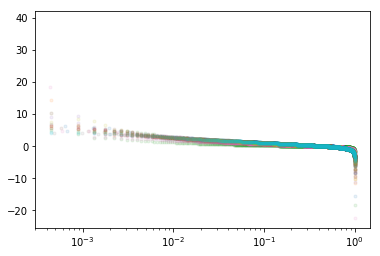

In [271]:
i = np.random.permutation(range(r.shape[1]))[:20]

pp = p.iloc[:, i].dropna(how='all')
rr = r.iloc[:, i].dropna(how='all')

j = (pp > .10) & (pp < .90)

figure()
r.iloc[:, i].plot(kind='hist', bins=100, alpha=0.1)
figure()
plot(pp[j], rr[j], '.', alpha=0.1)
ax = gca()
figure()
plot(pp, rr, '.', alpha=0.1)
ax = gca()
ax.set_xscale('log')
figure()
plot(1 - pp, rr, '.', alpha=0.1)
ax = gca()
ax.set_xscale('log')

# Q: pick some random symbol

See how it is shaped. 

Probably best to look at "worst" across all symbols.

In [496]:
k = np.random.permutation(s.index)[0]
d = df[df.symbol == k][['high', 'low', 'open', 'close']]
print(k)
print(d.shape)

corr
(2272, 4)


In [497]:
for kk in ['high', 'low']:
    d[kk + '_lag'] = d[kk].shift(1)
cols = ['best', 'worst']
for kk in ['open', 'close']:
    for kkk in ['open', 'close']:
        name = '{}_{}'.format(kk, kkk)
        cols.append(name)
        d[name] = d[kkk] / d[kk].shift(1)
d['best'] = d.high / d.low_lag
d['worst'] = d.low / d.high_lag
d.head()

,high,low,open,close,high_lag,low_lag,open_open,open_close,close_open,close_close,best,worst
4762606,17.73,16.219999,17.639999,16.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4762595,14.10,13.660000,13.970000,13.78,17.73,16.219999,0.791950,0.781179,0.855481,0.843846,0.869297,0.770446
4762596,14.08,13.750000,13.750000,13.97,14.10,13.660000,0.984252,1.000000,0.997823,1.013788,1.030747,0.975177
4762597,15.89,14.110000,14.110000,15.59,14.08,13.750000,1.026182,1.133818,1.010021,1.115963,1.155636,1.002131
4762598,15.62,15.000000,15.520000,15.04,15.89,14.110000,1.099929,1.065911,0.995510,0.964721,1.107016,0.943990


,best,worst,open_open,open_close,close_open,close_close
count,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000
mean,1.029183,0.977461,1.002924,1.003188,1.002644,1.002890
std,0.080071,0.074756,0.077098,0.076581,0.076475,0.075740
min,0.491007,0.463121,0.475134,0.487657,0.473440,0.485918
25%,1.010083,0.964643,0.988012,0.991128,0.990117,0.988095
50%,1.020951,0.980052,1.000000,1.000000,1.000000,1.000000
75%,1.038165,0.990113,1.012579,1.011428,1.008642,1.012208
max,2.151608,1.996337,2.112199,2.082078,2.057960,2.028613


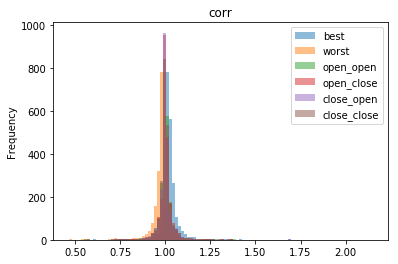

In [498]:
d = d.dropna()
d[cols].plot(kind='hist', bins=100, alpha=0.5)
title(k)
d[cols].describe()

In [499]:
import scipy.stats.distributions as ssd
for kk in cols:
    figure()
    z = ssd.norm(*ssd.norm.fit(d[kk]))
    logz = ssd.lognorm(*ssd.lognorm.fit(np.log(d[kk])))
    pareto = ssd.pareto_gen(*ssd.pareto_gen.fit())
    n = d.shape[0]
    p = np.linspace(1./n, 1 - 1./n, n)
    x = d[kk].values.copy() - 1
#     x = z.rvs(n) - 1 # to test
    x.sort()
    plot(x, x)
    plot(x, z.ppf(p) - 1, '.')
    plot(x, np.exp(logz.ppf(p)) - 1, '.')
    xlabel('real')
    ylabel('theor dist')
    title(kk)

TypeError: fit() missing 2 required positional arguments: 'self' and 'data'

<Figure size 432x288 with 0 Axes>

In [138]:
x

array([-0.9697074 , -0.96493417, -0.92481096, ..., 12.51918999, 12.74523988, 31.61363449])

array([1.15174961, 1.114776  , 1.11798085, ..., 1.16810984, 1.15132877,        nan])